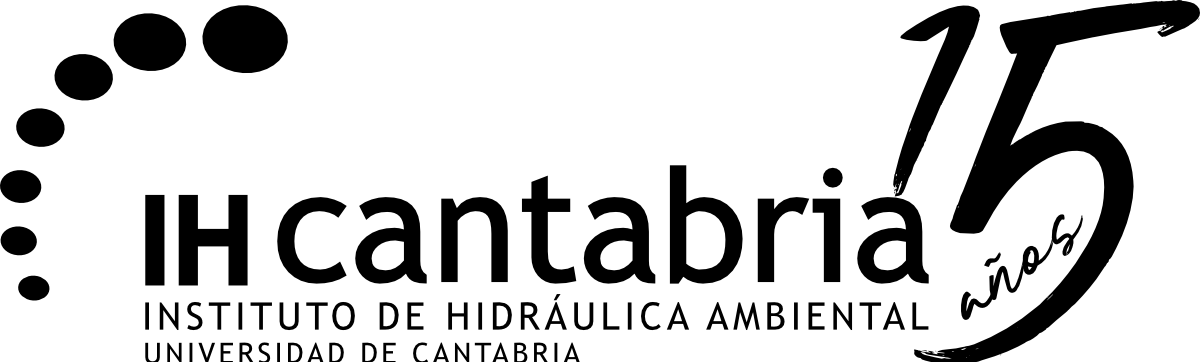


---



# **Capacitacion en el uso de las Bases de Datos de dinámicas marinas en Panamá**





##INTRODUCCIÓN

Este documento se enmarca dentro del marco del proyecto “Desarrollo de una base de datos de dinámicas marinas en las costas panameñas para evaluar impactos y vulnerabilidad por ascenso del nivel del mar”, financiada por Naciones Unidas, a través del Centro y Red de Tecnología del Clima (CTCN, por sus siglas en inglés). Este proyecto ha sido desarrollado por el Instituto de Hidráulica Ambiental de la Universidad de Cantabria (IHCantabria, España), en colaboración con el Ministerio de Ambiente de Panamá.

La última actividad planteada en dicho proyecto consiste en la capacitación y transferencia de conocimientos en cuanto al uso y aplicaciones de las bases de datos desarrolladas, mediante el desarrollo de talleres formativos impartidos por expertos de IHCantabria.

Información detallada sobre las bases de datos desarrolladas (en concreto, sobre los datos de partida, modelos numéricos empleados, resultados obtenidos,  características de los productos generados, etc.) se pueden encontrar en los distintos entregables del proyecto.

Este documento recoge una serie de ejercicios programados en Python, para la lectura y representación de las bases de datos de oleaje y nivel del mar en Panamá. Estos códigos son abiertos y las funciones específicas desarrolladas se pueden consultar en el fichero panama_fun.py, que se encuentra en la carpeta compartida del Drive.

Este documento se divide en dos grandes bloques, que corresponden con dos tipos de productos desarrollados en el marco del proyecto:
- Series temporales horarias entre 1993-2021 de oleaje y nivel del mar almacenadas en ficheros de texto, disponibles en 1454 puntos a lo largo de la costa panameña.
- Datos espacio-temporales de oleaje y nivel del mar en la zona marino-costera de Panamá durante el periodo 1993-2021 en ficheros con formato NetCDF.

Para el desarrollo de estas actividades no se requieren conocimientos de programación. Pulsando el botón de "Play" de cada sección, se ejecutan los códigos presentes en el mismo, obteniendo como resultado distintas figuras interactivas, que se pueden descargar y trabajar en ellas. Para que los ejercicios funcionen correctamente, se recomienda ejecutar las distintas secciones **secuencialmente**.

********************************************************************************


Antes de comenzar las actividades, es necesario instalar una serie de paquetes, importar funciones específicas, así como montar la carpeta del drive donde se ecuentran almancenados los ficheros que se van a utilziar durante la actividad:

In [1]:
!pip install geopandas;
#instalacion de geopandas
#GeoPandas es una librería  para trabajar con datos geoespaciales. Permite leer
#escribir, manipular y analizar datos geoespaciales en un formato  amigable.
!pip install windrose
# para plotear los graficos en direccional

from google.colab import drive
drive.mount('/content/drive')
#Montamos Google Drive como si fuese un disco duro
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
import glob
import natsort
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import xarray as xr

from plotly.offline import plot
from windrose.windrose import WindroseAxes
from shapely.affinity import affine_transform as T
from shapely.affinity import rotate as R
import shapely.geometry
#importacion de todas las librerias externas necesarias
sys.path.append('/content/drive/MyDrive/Panama2023')
#libreria con todo el codigo adicional necesario
import panama_fun as pnm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


Ya estamos listos para comenzar los ejercicios.



## BLOQUE I: Lectura y uso de las series temporales almancenadas en ficheros de texto

Se han seleccionado 1454 puntos a lo largo de la costa panameña, con una resolución aproximada de ~2 km. En dichos puntos, se dispone de las series temporales horarias de las distintas variables de oleaje y nivel del mar desde enero de 1993 a diciembre de 2021 en formato de texto.

### Representación de la localización de los puntos costeros

A continuación, se cargan los datos y se representa la localización de los puntos costero, con la paleta de colores indicando la profundidad en los mismos.

In [ ]:
filePath = '/content/drive/MyDrive/Panama2023';
df_costeros = pd.read_table(filePath + '/puntos_costeros.txt', delimiter = '  ', names = ['lon','lat','dpt']);
# La variable 'filePath' es la ruta al archivo que se va a leer
# Se proporciona el nombre de las columnas para el DataFrame: 'lon', 'lat' y 'dpt'

In [ ]:
# La función scatter_mapbox de Plotly Express se utiliza para crear un gráfico de dispersión georreferenciado
# El argumento 'lat' especifica los valores de latitud de los  puntos, en coordenadas geográficas WGS84
# El argumento 'lon' especifica los valores de longitud de los puntos, en coordenadas geográficas WGS84
# El argumento 'color' especifica el color de los puntos en función de la columna 'dpt' del DataFrame, que corresponde con la profundidad en metros
# La función update_layout se utiliza para ajustar el diseño del mapa
# El argumento 'mapbox' especifica el estilo del mapa. En este caso, se utiliza el estilo "carto-positron"
fig_cost = px.scatter_mapbox(lat=df_costeros['lat'], lon=df_costeros['lon'], color=df_costeros['dpt'], range_color  = [0,30], labels = {'color':'depth [m]'},\
                             hover_data={'ID':np.arange(1,len(df_costeros['lat'])+1,1)}).update_layout(mapbox={"style": "carto-positron", "zoom": 6.5})
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig_cost.show()

### Representación de las series temporales

Una vez conocida la localización de los distintos puntos, podemos seleccionar el que nos interese, a fin de representar las condiciones de oleaje y nivel del mar en el mismo. Para ello, necesitamos conocer el ID del punto objetivo y lo escribiremos en la siguiente sección de código. Para conocer dicho ID, basta con colocar el ratón sobre el punto objetivo y se abre la ventana con la información para ese punto.

A modo de ejemplo, se ha seleccionado el punto costero con ID 965, localizado frente a la costa de la provincia de los Santos, en el litoral Pacífico panameño. Las coordenadas de este punto son: [-80.5835º,7.2209º]. A continuación, se represetna la localización del punto seleccionado.


In [ ]:
# La variable 'filePath' es la ruta del directorio que contiene los archivos de texto
# La función glob se utiliza para encontrar todos los archivos que terminan en '.txt' en el directorio especificado
# Los resultados se almacenan en una lista
files = natsort.natsorted(glob.glob(filePath +'/ficheros_txt/*.txt.gz'))

ID=965 # a modificar por el usuario
fileID = pnm.find_file_ID(files,ID)
df = pnm.read_txt(fileID)

# Se extrae la localización y profundidad del punto objetivo:
latitudes = [df_costeros['lat'][ID-1]]
longitudes = [df_costeros['lon'][ID-1]]
profundidades = [df_costeros['dpt'][ID-1]]

# Crea una figura con un mapa de fondo
fig = go.Figure(go.Scattermapbox(lat=latitudes, lon=longitudes, mode='markers',
                                  marker=dict(size=10, color=profundidades, colorscale='jet'),
                                  text=['Profundidad: {}'.format(p) for p in profundidades],
                                  hoverinfo='text'))

# Configura el diseño del mapa
fig.update_layout(mapbox_style='stamen-terrain', mapbox_zoom=10, mapbox_center=dict(lat=latitudes[0], lon=longitudes[0]))

# Muestra la figura
fig.show()

La siguiente sección representa la serie temporal horaria desde 1993 a 2021 para dos variables de oleaje seleccionadas. La nomenclatura y descripción de las distintas variables contenidas en los ficheros de texto que se pueden representar son las siguientes:

•	Fecha: UTC [año mes día hora].

•	hs: altura de ola significante (metros).

•	tm02: periodo medio del oleaje (segundos).

•	tp: periodo de pico del oleaje (segundos).

•	dir: dirección media del oleaje (grados sexagesimales, desde el Norte, sentido horario). Convención de direcciones: Las direcciones indican de dónde viene el flujo.

•	nivel: sobreelevación del nivel del mar por marea astronómica y meteorológica (metros). También conocido como nivel del mar compuesto.

•	marea: sobreelevación del nivel del mar por marea astronómica (metros).

Por tanto, en la siguiente sección del código se puede modificar el argumento "y" a fin de representar las variables que nos interesen. Por defecto, aparece la altura de ola (hs) y el periodo de pico (tp).



In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="hs")
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'tp' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="tm02")
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

Hacemos lo mismo con las variables de nivel del mar. Por un lado, representamos la marea astronómica y, por el otro, la marea meteorológica (o *non-tidal residual*, NTR, en inglés), que es la resta del nivel del mar compuesto menos la marea astronómica.

In [ ]:
fig = px.line(df, x='Datetime', y="marea")
fig.show()

fig = px.line(df, x='Datetime', y=df['nivel']-df['marea'],labels={'y':'NTR'})
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'marea' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="marea")
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig2 = px.line(df, x='Datetime', y="hs")
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig2.show()

La siguiente aplicación que puede resultar de interés consiste en representar las condiciones de oleaje y nivel del mar en el punto objetivo para un periodo de tiempo concreto (por ejemplo, un año, un mes o unas semanas en las que sabemos que se produjeron fuertes oleajes, etc.).

A modo de ejemplo, seleccionamos el año 2015 para observar las condiciones de oleaje y nivel durante ese año. Por un lado, se trata de un año de El Niño, por lo que es interesante observar el comportamiento de la variable “residuo no meteorológico” durante ese año. Por otro lado, entre el 27 de abril y el 5 de mayo de 2015 se produjo un fuerte evento de inundación causado por fuertes oleajes que afectaron a toda la costa pacífico de Centroamérica. Resaltamos ese evento en nuestros gráficos para observar el comportamiento de las distintas variables.

Para ello, en la siguiente sección debemos especificar la fecha de inicio y final del periodo de tiempo que queremos representar (formato *yyyy-mm-dd*). La fecha de inicio ha de ser igual o posterior al 1 de enero de 1993 y la de fin igual o inferior al 31 de diciembre de 2021. La variable que se va a representar por defecto es la altura de ola, pero se puede modificar por cualquiera de las comentadas anteriormente.

In [ ]:
# Selecciona los datos entre las fechas especificadas
startDate = '2015-01-01'
endDate = '2015-12-31'
# Selecciona los datos dentro del intervalo de fechas a resaltar (resaltamos el evento de inundación).
highlight_startDate = '2015-04-27'
highlight_endDate = '2015-05-05'
df_time=df.loc[(df['Datetime'] >=startDate) & (df['Datetime'] <= endDate)]
df_highlight = df.loc[(df['Datetime'] >= highlight_startDate) & (df['Datetime'] <= highlight_endDate)]
# Crea una figura
fig = go.Figure()
# Agrega una serie de datos para el intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df_highlight['Datetime'], y=df_highlight['hs'], mode='lines', line=dict(color='red', width=3), name='Evento de inundación'))
# Agrega una serie de datos para los datos fuera del intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df_time['Datetime'], y=df_time['hs'], mode='lines', line=dict(color='blue', width=1), name = 'hs'))
# Personaliza el gráfico
fig.update_layout(title='Altura de ola significante {} y {}'.format(startDate, endDate),
                  xaxis_title='Fecha', yaxis_title='Altura de ola significante [m]')
# Muestra el gráfico
fig.show()

Hacemos lo mismo con la variable de marea astronómica. En concreto, vamos a representar el comportamiento de esta variable a lo largo de un mes (marzo de 2015) para observar el régimen de marea y su amplitud. Se distinguen dos picos y dos valles por día, que corresponde con una marea de tipo semidiurno. Además, se observa que la amplitud de la marea astronómica oscila entre 0.57 m y 1.94 m, que coincide con las fases lunares de cuarto menguante/creciente y luna llena/nueva, respectivamente.

In [ ]:
# Selecciona los datos entre las fechas especificadas
startDate = '2016-10-01'
endDate = '2016-10-31'
df_subset = df.loc[(df['Datetime'] >= startDate) & (df['Datetime'] <= endDate)]
# Crea una figura
fig = go.Figure()
# Agrega una serie de datos para los datos fuera del intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df_subset['Datetime'], y=df_subset['nivel'], mode='lines', line=dict(color='blue', width=1)))
# Personaliza el gráfico
fig.update_layout(title='Comportamiento de la marea astronomica entre {} y {}'.format(startDate, endDate),
                  xaxis_title='Fecha', yaxis_title='marea astronomica [m]')
# Muestra el gráfico
fig.show()

### Rosa de Oleaje

Es interesante conocer las direcciones de procedencia del oleaje que alcanza el punto objetivo, así como la energía asociada a cada dirección. Para ello, representamos la rosa direccional del oleaje que indica las direcciones de procedencia del mismo, con los colores indicando las alturas de ola para cada dirección.

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection="windrose")
title = 'Hs'
ax.set_title(title,fontdict = {'fontsize':20})

ax.bar(df['dir'],df['hs'], normed=True, opening=0.8, edgecolor='white',bins=np.arange(0, 2, 0.25), nsector = 30)
ax.legend(fontsize = 'x-large')


plt.suptitle('Rosa de Oleaje', fontsize = 'xx-large')
plt.tight_layout()
plt.show()

## BLOQUE II: Lectura y representación de los datos espacio-temporales en ficheros NETCDF

Los datos brutos generados en este proyecto mediante modelado numérico se han almacenado en ficheros con formato NetCDF. Estos ficheros tienen la ventaja de almacenar variables multi-dimensionales de forma eficiente y presentar una serie de atributos que describen las características tanto del fichero como de las variables contenidas en el mismo. Los archivos creados se han organizado en 4 carpetas, correspondientes a ambas cuencas (Caribe/Pacífico) y al tipo de dinámica (Olejae/Nivel). Son ficheros mensuales, por lo que hay 348 ficheros NetCDF (29 años*12 meses) en cada carpeta. Debido a su gran peso, a la carpeta Drive sólo se han subido los ficheros correspondientes al año 2016 para las 4 bases de datos, que es con lo que vamos a trabajar a continuación.

### Representación de la localización de los puntos contenidos en los NetCDF

Lo primero que vamos a hacer es representar la localización de los puntos almacenados en los NetCDF donde se tiene información temporal. Estos puntos corresponden con los nodos de la malla numérica empleada en el modelado de las dinámicas marinas. La paleta de colores indica la profundidad en cada punto.

In [ ]:
netCdfFiles = pnm.list_dirs(os.path.join(filePath,"ficheros_netcdf"))
pnm.plot_dpt_netcdf(filePath)
nivelC = pnm.get_temporal_series(netCdfFiles['NIVEL']['CARIBE'])
olasC = pnm.get_temporal_series(netCdfFiles['OLAS']['CARIBE'])

La siguiente sección presenta el contenido de un fichero NetCDF, donde se observa el nombre y características de las distintas variables:

In [ ]:
olasC

### Representación de mapa espacial de oleaje

Lo primero que podemos hacer con un fichero NetCDF es representar el mapa espacial de una variable en un instante en concreto. Es decir, representar el valor de una variable en cada punto del dominio para un instante dado.

A modo de ejemplo, a continuación se van a representar tanto las condiciones de la altura de ola como la dirección media de procedencia del oleaje el día 22 de noviembre de 2016 a las 06:00h en la cuenca Caribe. Este instante corresponde con el paso del huracán Otto por el mar Caribe, que se produjo entre el 17 y el 26 de noviembre.

Tanto la varible (Hs) como el instante a representar puede ser modificado por el usuario.

In [ ]:
t = px.scatter_mapbox(lat=olasC.lat, lon=olasC.lon, color=olasC['hs'].sel(time = '2016-11-22T06:00:00')[:,0], labels = {'color':'hs [m]'}, range_color = [0,3], title = 'Altura de ola (m)').update_layout(mapbox={"style": "carto-positron", "zoom":6})
t.show()
pnm.quiver_map(olasC, step = 5, fecha = '2016-11-22T06:00:00', title= 'Dirección media del oleaje en {}'.format('2016-11-22T06:00:00'))

### Representación de serie temporal

En segundo lugar, nos interesa representar la serie temporal de las variables en el año 2016 en un punto en concreto.
A modo de ejemplo, hemos seleccionado un punto frente a la costa de Colón (con coordenadas -79.925406º, 9.513541º) donde representamos el comportamiento de las variables de altura de ola y nivel del mar. Resaltamos las fechas en las que se pordujo el huracán Otto a fin de observar el efecto que tuvo en ambas variables.

Tanto las coordenadas del punto objetivo como las variables a representar pueden ser modificadas por el usuario.

In [ ]:
olasC_sel = pnm.sel_lonlat(olasC,lon = -79.925406,lat = 9.513541) # coordenadas del punto objetivo
nivelC_sel = pnm.sel_lonlat(nivelC,lon = -79.925406,lat = 9.513541) # coordenadas del punto objetivo
# Huracan Otto (17-26 Nov):
#------------Start la fecha--------
startDate = '2016-11-17T00:00:00'# fechas a resaltar
endDate = '2016-11-27T00:00:00'# fechas a resaltar

fig = go.Figure()
fig.add_trace(go.Scatter(x=olasC_sel['time'], y=olasC_sel['hs'],
                    mode='lines',
                    name='hs'))
fig.add_trace(go.Scatter(x = olasC_sel['time'].loc[dict(time=slice(startDate,endDate))],\
                         y = olasC_sel['hs'].loc[dict(time=slice(startDate,endDate))],
                    mode='lines',
                    name='Huracán Otto'))
fig.update_layout(title='Altura de Ola (m) entre {} y {}'.format(startDate, endDate)
                  )
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=nivelC_sel['time'], y=nivelC_sel['level'],
                    mode='lines',
                    name='nivel'))
fig.add_trace(go.Scatter(x = nivelC_sel['time'].loc[dict(time=slice(startDate,endDate))],\
                         y = nivelC_sel['level'].loc[dict(time=slice(startDate,endDate))],
                    mode='lines',
                    name='Huracán Otto'))
fig.update_layout(title='Nivel del Mar (m) entre  {} y {}'.format(startDate, endDate))
fig.show()

### Representación de mapa espacial de nivel del mar

Por último, vamos a representar dos mapas espaciales de nivel del mar en la costa Pacífico, donde se observan condiciones de pleamar y bajamar, respectivamente. En concreto, representamos los instantes del 3 de noviembre de 2016 a las 11:00h y a las 17:00h. Es interesante observar la amplificación de la onda de marea en el interior del Golfo de Panamá.

Las fechas a representar pueden ser modificadas por el usuario.


In [ ]:
nivelP = pnm.get_temporal_series(netCdfFiles['NIVEL']['PACIFICO'])

In [ ]:
t = px.scatter_mapbox(lat=nivelP.lat, lon=nivelP.lon, color=nivelP['level'].sel(time = '2016-11-03T11:00:00')[:,0], labels = {'color':'Nivel del mar [m]'}, range_color=[0,2]).update_layout(mapbox={"style": "carto-positron", "zoom":6})
t.show()
t2 = px.scatter_mapbox(lat=nivelP.lat, lon=nivelP.lon, color=nivelP['level'].sel(time = '2016-11-03T17:00:00')[:,0], labels = {'color':'Nivel del mar [m]'}, range_color= [-2,1]).update_layout(mapbox={"style": "carto-positron", "zoom":6})
t2.show()